# A complete Hugging Face tutorial: how to build and train a vision transformer

This article serves as an all-in tutorial of the Hugging Face ecosystem. We will explore the different libraries developed by the Hugging Face team such as transformers and datasets. We will see how they can be used to develop and train transformers with minimum boilerplate code. To better elaborate the basic concepts, we will showcase the entire pipeline of building and training a Vision Transformer (ViT).

I assume that you already are familiar with the architecture so we won’t analyze much about it. A few things to remember are:

1. In ViT, we represent an image as a sequence of patches .

1. The architecture resembles the original Transformer from the famous “Attention is all you need” paper.

1. The model is trained using a labeled dataset following a fully-supervised paradigm.

1. It is usually fine-tuned on the downstream dataset for image classification.

If you are interested in a holistic view of the ViT architecture, visit one of our previous articles on the topic: [How the Vision Transformer (ViT) works in 10 minutes: an image is worth 16x16 words.](https://theaisummer.com/vision-transformer/)

In [1]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests

In [2]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Egyptian cat


In [7]:
from datasets import load_dataset, ClassLabel
ds =load_dataset('beans')
ds

Using custom data configuration default
Reusing dataset beans (/root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [5]:
ex = ds['train']
image = ex['image']
image

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 <PIL.Jpeg

In [6]:
labels = ds['train'].features['labels']
labels

ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [8]:
ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], names_file=None, id=None)

ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [9]:
labels.int2str(ex['labels'])

['healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'he

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

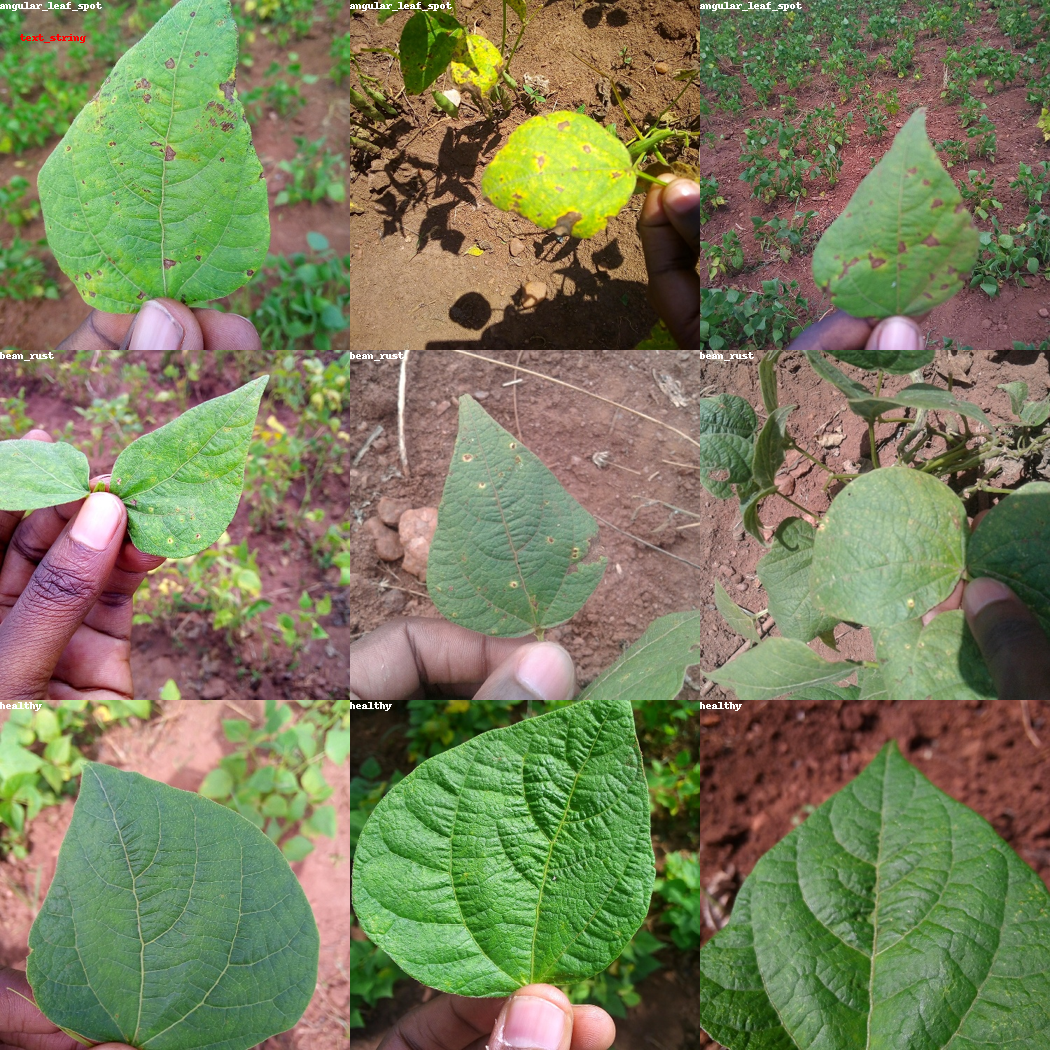

In [14]:
import random
from PIL import ImageDraw, ImageFont, Image
# font = ImageFont.load_default()

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    
    # font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)
            draw.text(( 20, 32), "text_string", (255,0,0), font=font)


    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)


In [16]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [ ]:
feature_extractor(image, return_tensors='pt')


In [19]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.5373, -0.5059, -0.4431,  ...,  0.5529,  0.4510,  0.3255],
          [-0.6078, -0.5922, -0.5294,  ...,  0.4902,  0.3961,  0.2941],
          [-0.6627, -0.6784, -0.6000,  ...,  0.4039,  0.3098,  0.2392],
          ...,
          [ 0.1922,  0.2392,  0.1843,  ..., -0.1137, -0.1294, -0.1529],
          [ 0.3176,  0.2706,  0.1451,  ..., -0.1922, -0.1686, -0.1529],
          [ 0.1765,  0.1373,  0.0039,  ..., -0.3020, -0.2784, -0.3098]],

         [[-0.3804, -0.3412, -0.2549,  ...,  0.3882,  0.2549,  0.1059],
          [-0.4196, -0.4196, -0.3490,  ...,  0.2863,  0.1843,  0.0824],
          [-0.4510, -0.4824, -0.4196,  ...,  0.1843,  0.0980,  0.0275],
          ...,
          [ 0.7098,  0.8431,  0.8353,  ...,  0.5216,  0.4824,  0.4588],
          [ 0.9059,  0.9137,  0.7961,  ...,  0.4431,  0.4510,  0.4667],
          [ 0.8196,  0.7961,  0.6706,  ...,  0.3176,  0.3412,  0.3098]],

         [[-0.9843, -0.9922, -0.9922,  ..., -0.1451, -0.2706, -0.4118],
          [-1

In [20]:
ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

Using custom data configuration default
Reusing dataset beans (/root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
prepared_ds = ds.with_transform(transform)

In [26]:
exampleInstancs = prepared_ds['train'][0:2]
type(exampleInstancs)

transformers.feature_extraction_utils.BatchFeature

In [27]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [28]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


In [29]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
